# Milestone Project 1: Food Vision Big

In [1]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9af17a27-954e-17e1-4682-866fb7a35b8c)


In [2]:
# Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-21 00:10:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-21 00:10:14 (114 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Dependencies

In [3]:
from helper_functions import *
import tensorflow as tf
import matplotlib.pyplot as plt

# Get data

In [4]:
# TensorFlow datasets (TFDS)
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [6]:
(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data returns in (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete6IX7MP/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete6IX7MP/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get class names
class_names = ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101: 41,
  Class name: french_onion_soup,
  Min. pixel value: 0,
  Max. pixel value: 255
  


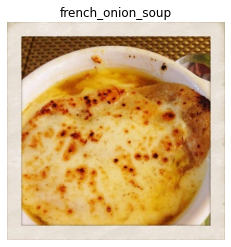

In [12]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # (image_tensor, label)

# See infos
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101: {label},
  Class name: {class_names[label.numpy()]},
  Min. pixel value: {tf.reduce_min(image)},
  Max. pixel value: {tf.reduce_max(image)}
  """)

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis('off');

# Preprocess data

What we know about our data:
* In `uint8` dataype;
* Different sized images;
* Not scaled.

What we know models like:
* Data in `float32` type (or for mixed precision `float16` and `float32`);
* For batches, TF likes all tensors to be the same size (images with same size);
* Scaled pixels (between 0 and 1).

> Since we'll be using **EfficientNetBX** pretrained models from `EfficientNetBX` we do not need to apply rescale in our data (these architectures have rescaling built-in.

In [13]:
# Function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts img datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels].
  """

  image = tf.image.resize(image, [img_shape, img_shape])
  
  return tf.cast(image, tf.float32), label

In [15]:
# Preprocess a single image and check output

preprocessed_img = preprocess_img(image, label)
preprocessed_img

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[194.12755, 174.12755, 149.12755],
         [204.66325, 184.66325, 159.66325],
         [198.20918, 180.42348, 158.85204],
         ...,
         [200.12253, 186.55106, 160.97958],
         [204.22949, 190.22949, 164.22949],
         [195.14168, 179.14168, 154.14168]],
 
        [[197.10204, 177.10204, 150.10204],
         [202.5102 , 185.5102 , 159.5102 ],
         [209.96428, 193.83673, 169.47958],
         ...,
         [201.301  , 187.72952, 162.15805],
         [207.8622 , 193.8622 , 167.8622 ],
         [197.218  , 183.218  , 157.218  ]],
 
        [[192.0153 , 175.44388, 147.2296 ],
         [202.11224, 185.32652, 159.32652],
         [209.37755, 193.59183, 169.0204 ],
         ...,
         [205.13773, 191.28563, 167.99481],
         [208.99998, 194.99998, 168.99998],
         [201.62102, 187.62102, 161.62102]],
 
        ...,
 
        [[227.88795, 220.10222, 201.31648],
         [236.76028, 228.18881, 212.8623 ]

# Batch and prepare datasets

In [16]:
# Map preprocessing function to training data
train_data = train_data.map(map_func=preprocess_img,
                            num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train data, turn into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img,
                          num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

# tf.data.AUTOTUNE uses all processing power available, runs methods faster
# prefetch prepares next batch while GPU is learning patterns from previous batch

In [17]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Create modelling callbacks

In [18]:
checkpoint_path = 'model_checkpoints/cp.ckpt'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_acc',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

# Setup mixed precision training

Mixed precision combines float16 and float32 data types to speed up model performance.

In [20]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [21]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


# Build feature extraction model

In [22]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [23]:
INPUT_SHAPE = (224, 224, 3)

# Base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Functional API model
inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')

# EfficientNet already has built-in rescaling
# x = preprocessing.Rescaling(1./255.)(x)

x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

# Checking layer dtype policies

In [26]:
for layer in model.layers:
  print(layer.name,'|' ,layer.trainable,'|', layer.dtype,'|', layer.dtype_policy)

input_layer | True | float32 | <Policy "float32">
efficientnetb0 | False | float32 | <Policy "mixed_float16">
global_average_pooling2d | True | float32 | <Policy "mixed_float16">
dense | True | float32 | <Policy "mixed_float16">
softmax_float32 | True | float32 | <Policy "float32">


# Fit the feature extraction model

In [27]:
history_101_feature_extract = model.fit(train_data,
                                        epochs=3,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(0.15*len(test_data)),
                                        callbacks=[model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8228 - accuracy: 0.5564

2368/2368 [==============================] - 199s 76ms/step - loss: 1.8228 - accuracy: 0.5564 - val_loss: 1.2241 - val_accuracy: 0.6841
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2946 - accuracy: 0.6647

2368/2368 [==============================] - 166s 69ms/step - loss: 1.2946 - accuracy: 0.6647 - val_loss: 1.1288 - val_accuracy: 0.7005
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1443 - accuracy: 0.7018

2368/2368 [==============================] - 172s 72ms/step - loss: 1.1443 - accuracy: 0.7018 - val_loss: 1.0916 - val_accuracy: 0.6999


In [28]:
# Evaluate model on whole test dataset
results_feature_extraction = model.evaluate(test_data)

790/790 [==============================] - 49s 61ms/step - loss: 1.0839 - accuracy: 0.7070


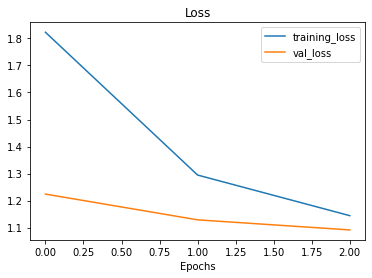

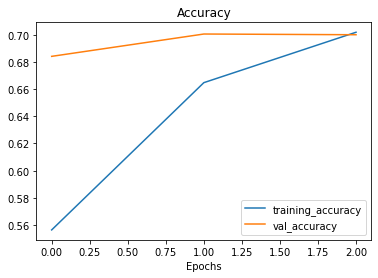

In [29]:
# See loss curves
plot_loss_curves(history_101_feature_extract)

# Fine-Tuning

In [30]:
model.layers

In [32]:
len(model.layers[1].trainable_variables)

0

In [33]:
base_model.trainable = True

# Freeze all layers, except for the last 20
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # when fine-tuning, you typically want to lower your lr by 10x
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
len(model.layers[1].trainable_variables)

19

In [35]:
# Fine tune for another 3 epochs
fine_tune_epochs = 3 + 3

# Refit the model
# The model is starting to train where it left off without fine-tuning
history_101_fine_tune = model.fit(train_data,
                                  epochs=fine_tune_epochs,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=int(0.15*len(test_data)),
                                  initial_epoch=history_101_feature_extract.epoch[-1],
                                  callbacks=[model_checkpoint])

Epoch 3/6
2367/2368 [============================>.] - ETA: 0s - loss: 0.9388 - accuracy: 0.7500

2368/2368 [==============================] - 184s 73ms/step - loss: 0.9388 - accuracy: 0.7500 - val_loss: 0.9672 - val_accuracy: 0.7362
Epoch 4/6
2367/2368 [============================>.] - ETA: 0s - loss: 0.7306 - accuracy: 0.8039

2368/2368 [==============================] - 183s 76ms/step - loss: 0.7307 - accuracy: 0.8039 - val_loss: 0.9422 - val_accuracy: 0.7431
Epoch 5/6
2367/2368 [============================>.] - ETA: 0s - loss: 0.5712 - accuracy: 0.8465

2368/2368 [==============================] - 166s 69ms/step - loss: 0.5712 - accuracy: 0.8465 - val_loss: 0.9640 - val_accuracy: 0.7436
Epoch 6/6
2367/2368 [============================>.] - ETA: 0s - loss: 0.4344 - accuracy: 0.8855

2368/2368 [==============================] - 165s 69ms/step - loss: 0.4344 - accuracy: 0.8855 - val_loss: 1.0282 - val_accuracy: 0.7423


In [36]:
# Evaluate model on whole test dataset
results_fine_tune = model.evaluate(test_data)

790/790 [==============================] - 48s 61ms/step - loss: 1.0097 - accuracy: 0.7419


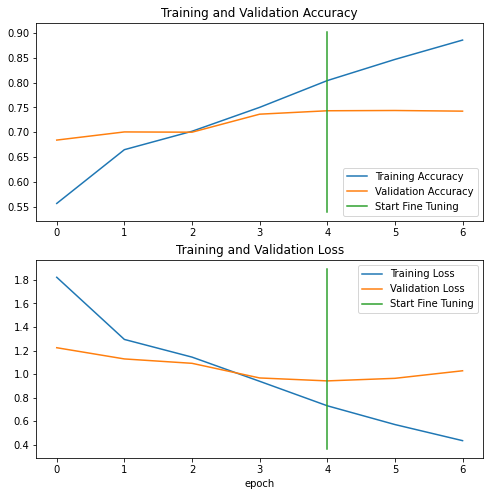

In [37]:
compare_historys(history_101_feature_extract, history_101_fine_tune)

# Visualizing predictions

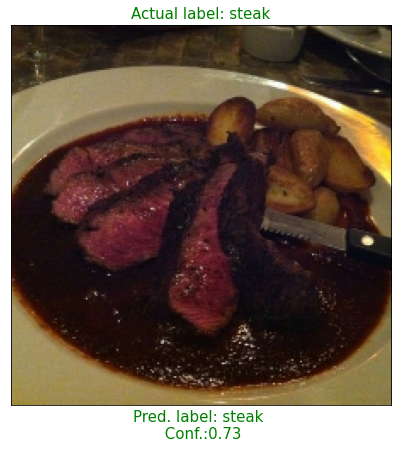

In [87]:
# Take samples from test data
for image, label in test_data.take(1):

  pred_prob = model.predict(tf.expand_dims(image[0], axis=0))

  pred_class = class_names[pred_prob.argmax()]
  
  plt.figure(figsize=(8,7))
  if class_names[label[0].numpy()] == pred_class:
    title_color='g'
  else:
    title_color='r'
  plt.title(f"Actual label: {class_names[label[0].numpy()]}", fontsize=15, c=title_color)
  plt.xlabel(f"Pred. label: {pred_class} \n Conf.:{pred_prob.max():.2f}", fontsize=15, c=title_color)
  plt.yticks([])
  plt.xticks([])
  plt.imshow(tf.cast(image[0], dtype=tf.int32));